# <b>시계열 프로젝트1</b>

## <b>01. 지도학습(1)</b>

### 매출 데이터 이용
#### Sales record for every product and store for Russian Software company 1C

### 계절성 있는 시계열 분석으로 미래 매출 내다보기

In [ ]:
import numpy as np
import pandas as pd  
import random as rd  
import datetime 
import matplotlib.pyplot as plt 
import seaborn as sns 

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import warnings
warnings.filterwarnings("ignore")

In [ ]:
filepath = 'https://github.com/mchoimis/tsdl/raw/main/sales/'
sales = pd.read_csv(filepath + 'train.csv') # 여기서는 train인 sales를 예측하고자 함.
item_cat = pd.read_csv(filepath + 'item-category.csv')
item = pd.read_csv(filepath + 'items.csv')
shops = pd.read_csv(filepath + 'shops.csv')
test = pd.read_csv(filepath + 'test.csv')

In [ ]:
# date 인덱스를 datetime 인덱스로 변환
print(sales.date)

0          02.01.2013
1          03.01.2013
2          05.01.2013
3          06.01.2013
4          15.01.2013
              ...    
2935844    10.10.2015
2935845    09.10.2015
2935846    14.10.2015
2935847    22.10.2015
2935848    03.10.2015
Name: date, Length: 2935849, dtype: object


In [ ]:
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y')) # UDF로 time index 만들기
print(sales.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [ ]:
print(sales.date)

0         2013-01-02
1         2013-01-03
2         2013-01-05
3         2013-01-06
4         2013-01-15
             ...    
2935844   2015-10-10
2935845   2015-10-09
2935846   2015-10-14
2935847   2015-10-22
2935848   2015-10-03
Name: date, Length: 2935849, dtype: datetime64[ns]


In [ ]:
sales.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0
6,2013-01-02,0,25,2565,549.00,1.0
7,2013-01-04,0,25,2572,239.00,1.0
8,2013-01-11,0,25,2572,299.00,1.0
9,2013-01-03,0,25,2573,299.00,3.0


In [ ]:
sales.tail(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935839,2015-10-24,33,25,7315,399.0,1.0
2935840,2015-10-31,33,25,7409,299.0,1.0
2935841,2015-10-11,33,25,7393,349.0,1.0
2935842,2015-10-10,33,25,7384,749.0,1.0
2935843,2015-10-09,33,25,7409,299.0,1.0
2935844,2015-10-10,33,25,7409,299.0,1.0
2935845,2015-10-09,33,25,7460,299.0,1.0
2935846,2015-10-14,33,25,7459,349.0,1.0
2935847,2015-10-22,33,25,7440,299.0,1.0
2935848,2015-10-03,33,25,7460,299.0,1.0


In [ ]:
# Aggregate to monthly level
# 월별로 정렬, 그룹바이로 모아서 본다. -> 시계열 데이터의 트렌드 등이 보일 수도 있기 때문.
monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])["date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

In [ ]:
# See monthly sales record
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

In [ ]:
# Number of items per category
x=item.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x

,item_category_id,item_name,item_id
0,40,5035,5035
1,55,2365,2365
2,37,1780,1780
3,31,1125,1125
4,58,790,790
5,30,756,756
6,72,666,666
7,19,628,628
8,61,598,598
9,23,501,501


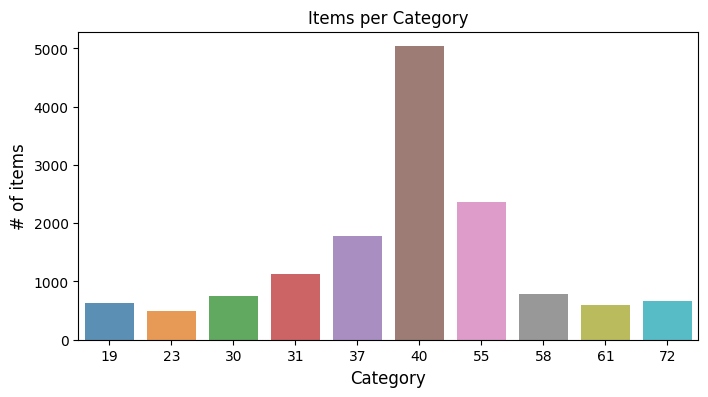

In [ ]:
# Visualize # Cross-sectional
# 2년동안 모아진 매출 정보를 합친것으로, 시간에 대한 변동된 정보는 알 수는 없다(Cross-sectional).
plt.figure(figsize=(8,4))
ax= sns.barplot(x=x.item_category_id, y=x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

In [ ]:
# Make time series
# 데일리 매출
ts=sales.groupby(["date"])["item_cnt_day"].sum()
ts.astype('float')
ts

date
2013-01-01    1951.0
2013-01-02    8198.0
2013-01-03    7422.0
2013-01-04    6617.0
2013-01-05    6346.0
               ...  
2015-10-27    1551.0
2015-10-28    3593.0
2015-10-29    1589.0
2015-10-30    2274.0
2015-10-31    3104.0
Name: item_cnt_day, Length: 1034, dtype: float64

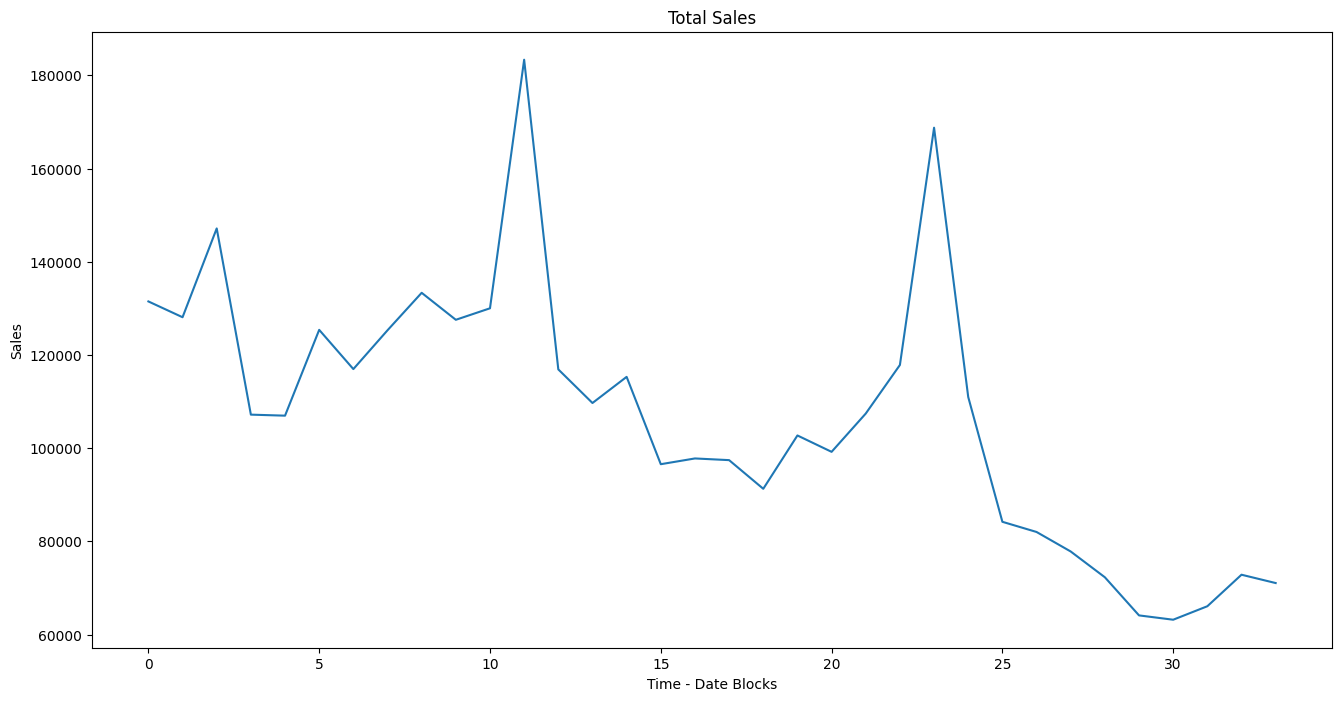

In [ ]:
ts = sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.plot(ts)
plt.xlabel('Time - Date Blocks') # Date Blocks: 3주에서 한달 정도 해당되는 길이
plt.ylabel('Sales')
plt.title('Total Sales')
plt.show()

# 밑의 그림은 yearly trend가 있다고 볼 수 있다. 
# 12정도에서 올라간다. Date Blocks 하나에 3주에서 한달 정도 해당되는 길이 이니 12이면 1년 정도 이다.
# 12이면 연말정도, 할로윈데이 정도이다. 이때 매출이 확 올라간다라고 볼 수 있다.

# 이러한 비정상 시계열을 정상 시계열로 변환한 다음에 통계적인 모델(AR,MA,ARMA,ARIMA)에 적용한다.
# 정상 시계열로 변환 : decomposition적용. 승법모형 트렌드, 계절성 등이 더하기로 이루어져있고 이것을 빼야한다. 가법모형은 곱하기로 이루어져있어 로그를 취한다음 더하기로 이루어지게 한 다음 제거 한다.
# 이렇게 제거하는것(빼주는것)은 차분으로 해결한다.
# 차분 후에 acf그래프, pcaf그래프를 이용해서 정상시계열인지 아닌지 판별, 또한 래그도 차분할때 어떤 차수를 가지고 해야지 옵티멀한지 확인가능.

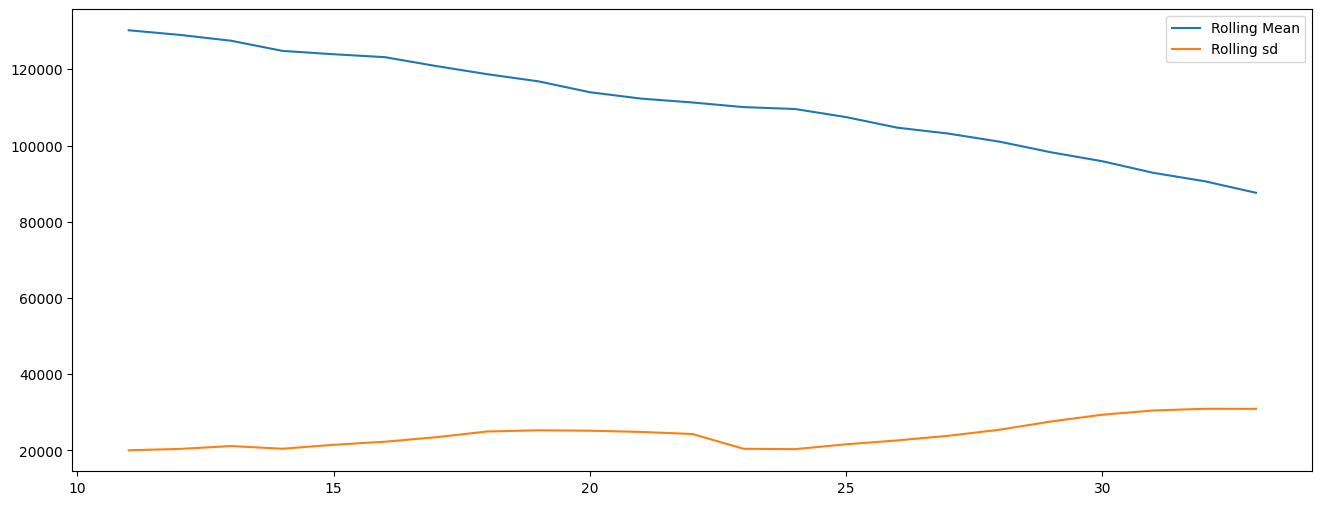

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend()
plt.show()

# 아래의 그림을 보면
# Rolling sd : 변동성은 커지고 있고, 
# Rolling Mean : 평균은 떨어지고 있다.
# 앞의 그림에서 트렌드는 연말에 피크를 치지만, 전체적인 트렌드는 감소하고 있다. 

##### 해당 데이터를 가지고 예측시에 문제점#####
# (1) 이 데이터를 가지고 스무딩을 한다음에 트렌드만 가지고 예측을 한다면 우리의 예측은 감소하는 것으로 나타날 것이다(trend variation). 하지만 할로윈데이/연말 같은 피크 타임을 예측 할 수 없다.
# (2) 피크시즌(seasonal variation)만 가지고 예측을 한다면 평소의 매출은 예측하지 못함.
# 따라서 trend variation과 seasonal variation을 둘다 설명할 수 있는 모델을 만들어야한다. -> 이런 설명을 보여주자 라는 것이 Prophet이라는 패키지의 존재 이유.

<Figure size 1600x1200 with 0 Axes>

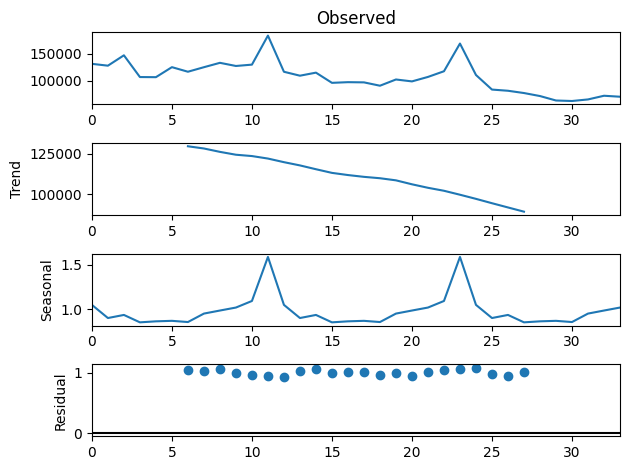

In [ ]:
import statsmodels.api as sm
# trend와 seasonal을 승법/가법 모형으로 적용해본다.
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,period=12,model="multiplicative")
plt.figure(figsize=(16,12))
fig = res.plot()
plt.show()

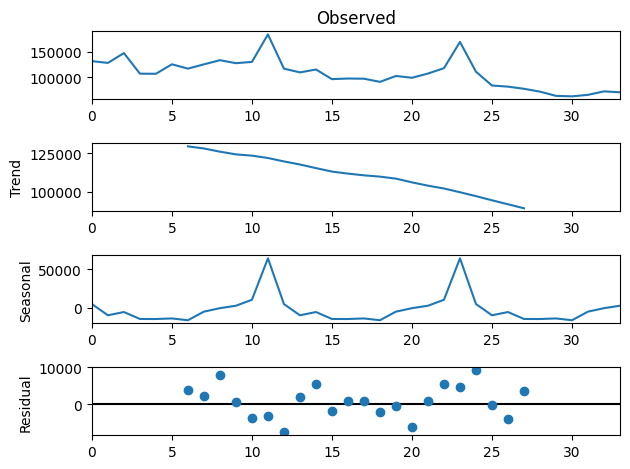

In [ ]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,period=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [ ]:
# 승법/가법모형으로 확인해본 결과 : 트렌드는 내려가고, 시즈널도 연말쯤에 있는 것으로 보인다. 
# 또한 residual이 랜덤노이즈여야 모든 요인들을 decompositon했다고 확인할 수 있다.

# 랜덤노이즈(white noisie)는 가우시안 분포를 따른다(평균이 0이고 분산이 1이다).
# 음양으로 왔다갔다 해야 랜덤이라고 볼 수 있는데, 승법모형은 패턴이 있는걸로 보인다.
# 따라서 이 데이터는 가법모형에 의한 (컴포넌트들이 더하기 형식으로 되어있다) 것으로 볼 수 있다.

# 대부분의 시계열 데이터는 기본적으로 가법모형에 의해 컴포넌트들이 합쳐져 있다고 볼 수 있다. 

In [ ]:
# Testing for Stationarity
# 정상 시계열 인지 테스트
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

# Dickey-Fuller test 결과
# Test Statistic(검정통계량)이 Critical Value들에 있지않다 라고 결론 내린다면 rejection이다.
# 따라서 기각하기 위해서는 p-value는 낮은것일 수록 좋다. 
# 그러나 아래의 결과를 보면 P-value가 낮지 않다. (86% 확률로 Critical Value에 있지 않다, 더 높은 확률로 있지 않아야한다)

# 따라서 해당 테스트 결과로 비정상 시계열임을 알 수 있다.

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
# Lags Used                     0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [ ]:
# 따라서 정상시계열로 바꾸기 위해 trend를 제거해본다.

In [ ]:
# Remove Trend (t) component
from pandas import Series as Series

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

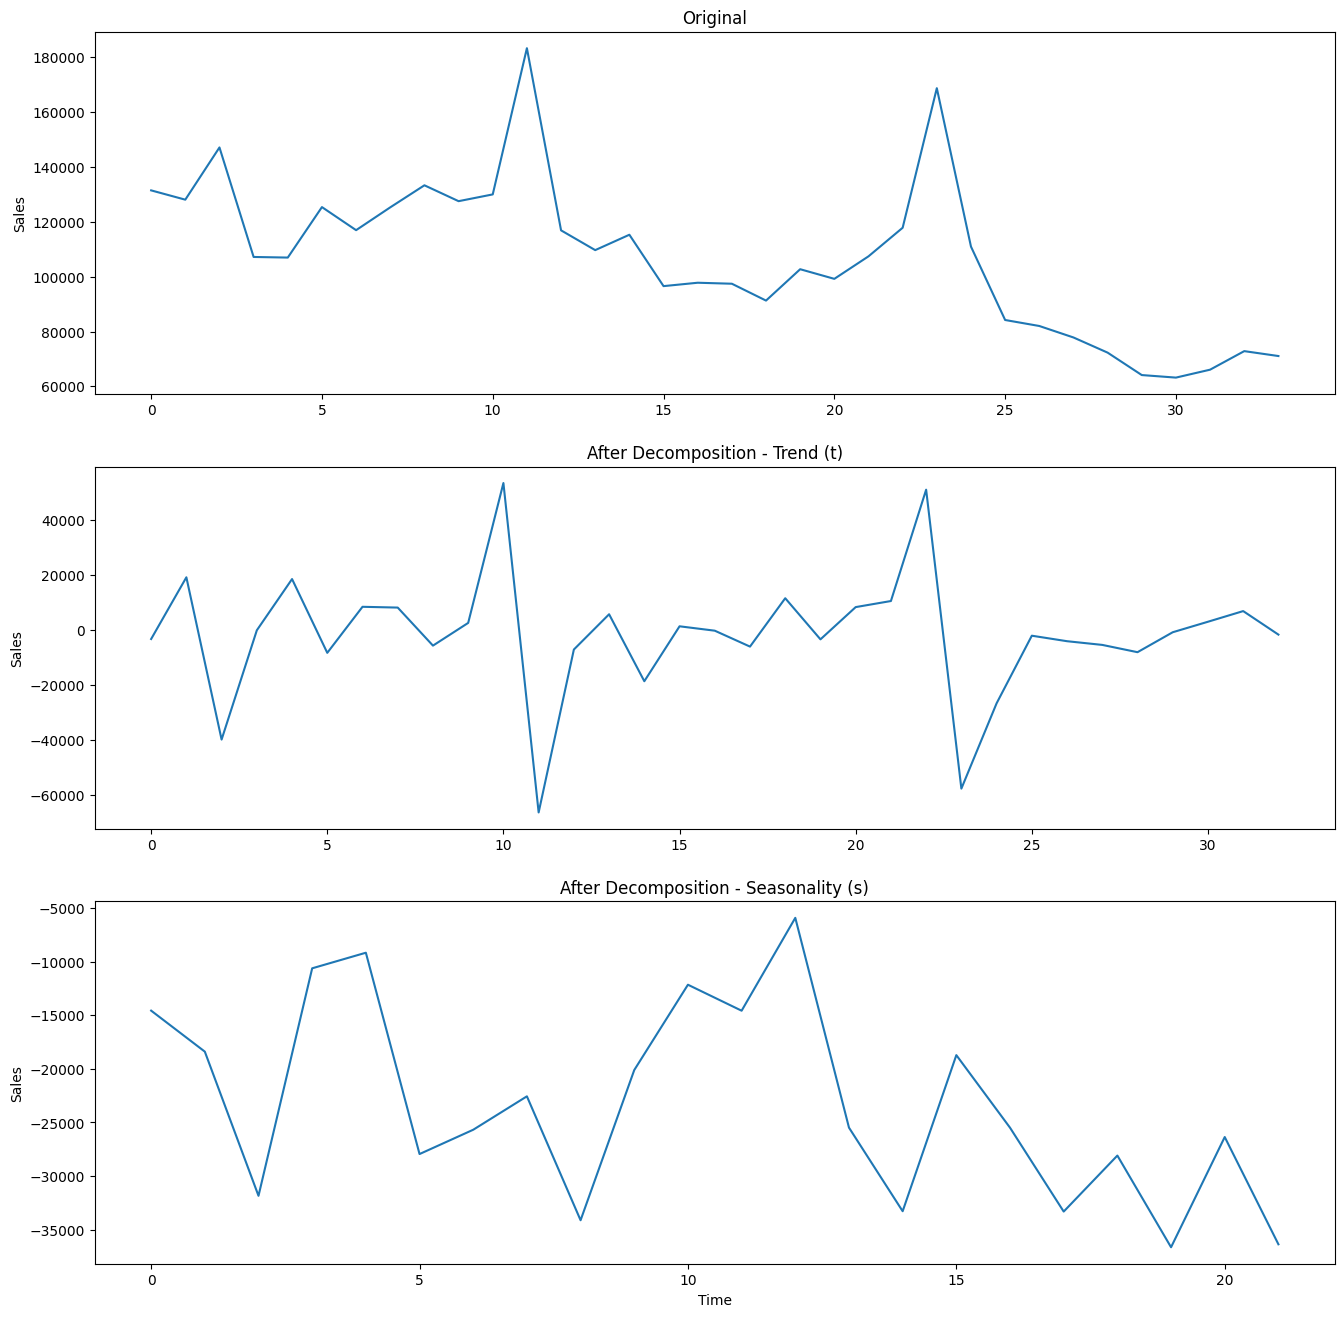

In [ ]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')

plt.figure(figsize=(16,16))

plt.subplot(311)
plt.title('Original')
plt.ylabel('Sales')
plt.plot(ts)

plt.subplot(312)
plt.title('After Decomposition - Trend (t)') # trend를 제거한 그림
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()
# trend를 제거하여 계절성만 보인다.

plt.subplot(313)
plt.title('After Decomposition - Seasonality (s)') # seasonal을 제거한 그림
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()
# seasonal을 제거하니 거의 랜덤한 요소만 남은것으로 보인다.

In [ ]:
# Testing for stationarity after decomposition
test_stationarity(new_ts)

# 따라서 다시 테스트를 진행해보니 p-value가 많이 낮아졌다.
# 기본적으로 p-value는 0.05 보다는 낮아야한다.
# 어느정도는 정상화 되었구나 라는 결론낼 수 있다.

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
# Lags Used                     0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


### 심화 Point: Prophet 패키지 이용하여 수요 예측하기

In [ ]:
# 앞선 방법들 보다 간단하게 prophet 패키지 이용해서 예측하기

In [ ]:
from prophet import Prophet

In [ ]:
# Make inout data for Prophet 

In [ ]:
# Add dates to Time-series as index
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS') # Month Start
ts=ts.reset_index()
ts.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


In [ ]:
ts.columns=['ds','y'] # 컬럼명을 이렇게 바꾸어주어야 prophet이 인식을 한다.

In [ ]:
# model = Prophet(model_params)
model = Prophet(yearly_seasonality=True)  # Intantiate the model
# 여기서는 계절성만 따져 보고 싶어서 계절성만 true로 설정, 계절성을 반영한 모델을 만든다.
# 만약 증가하는 형태이면(여기서는 지금 증가하는 형태가 아니라 뺐음)
## model = Prophet(yearly_seasonality=True, growth="linear")

In [ ]:
# Prophet params
# Example

# growth(values = c("linear", "logistic"))

# 값이 바뀌는 부분 지정가능
# changepoint_num(range = c(10L, 50L), trans = NULL)
# changepoint_range(range = c(0.6, 0.9), trans = NULL)

# seasonality_yearly(values = c(TRUE, FALSE))
# seasonality_weekly(values = c(TRUE, FALSE))
# seasonality_daily(values = c(TRUE, FALSE))

# prior_scale_changepoints(range = c(-3, 2), trans = log10_trans())
# prior_scale_seasonality(range = c(-3, 2), trans = log10_trans())
# prior_scale_holidays(range = c(-3, 2), trans = log10_trans())

In [ ]:
model = Prophet(yearly_seasonality=True) # Prophet object can only be fit once. Instantiate a new object when running multiple times
model.fit(ts) # fit the model 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptk7fsx1r/frohsbxn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptk7fsx1r/ydfj7vip.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5989', 'data', 'file=/tmp/tmptk7fsx1r/frohsbxn.json', 'init=/tmp/tmptk7fsx1r/ydfj7vip.json', 'output', 'file=/tmp/tmptk7fsx1r/prophet_model_cdujqb0/prophet_model-20230530064850.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:48:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:48:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Predict for five months in the furure
# 아까 만든 모델로 예측해본다.
future = model.make_future_dataframe(periods = 5, freq = 'MS')  # MS - month start
forecast = model.predict(future)

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
# yhat: 예측 결과
# 시계열 데이터의 예측치 yhat의 lower, upper 값을 제공해주어야한다.
# 시계열 데이터는 변동성이 높고, 설명할 수 있는 포인트 들이 넓기 때문이다. 구간 estimate도 중요하다.

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,83193.968321,80257.996572,86393.409264
35,2015-12-01,125513.233878,122268.775539,128547.750857
36,2016-01-01,75625.687412,72329.904751,78533.828274
37,2016-02-01,40109.309246,36870.642127,43612.029900
38,2016-03-01,76664.069697,73699.001820,79673.389646


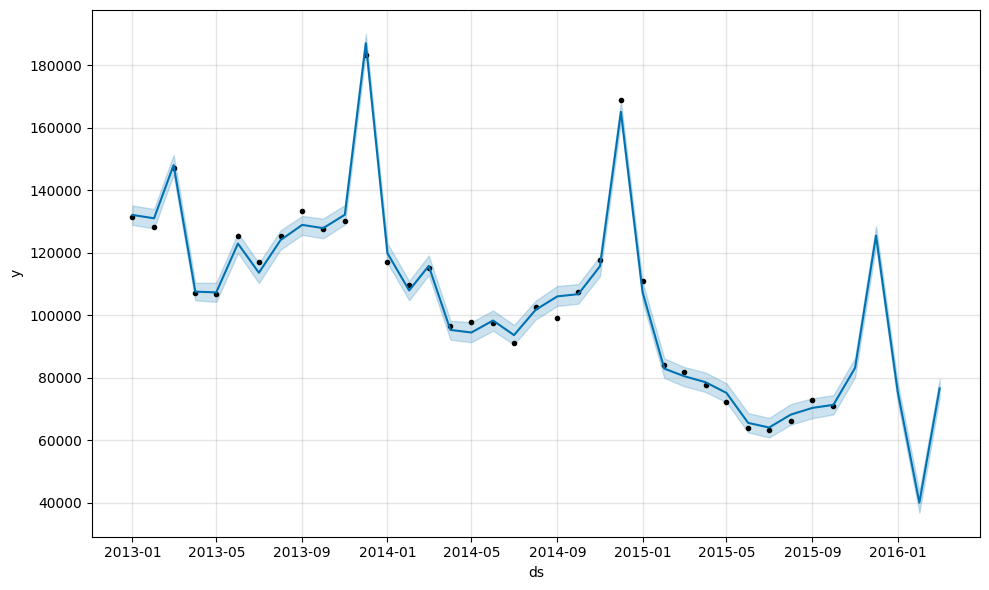

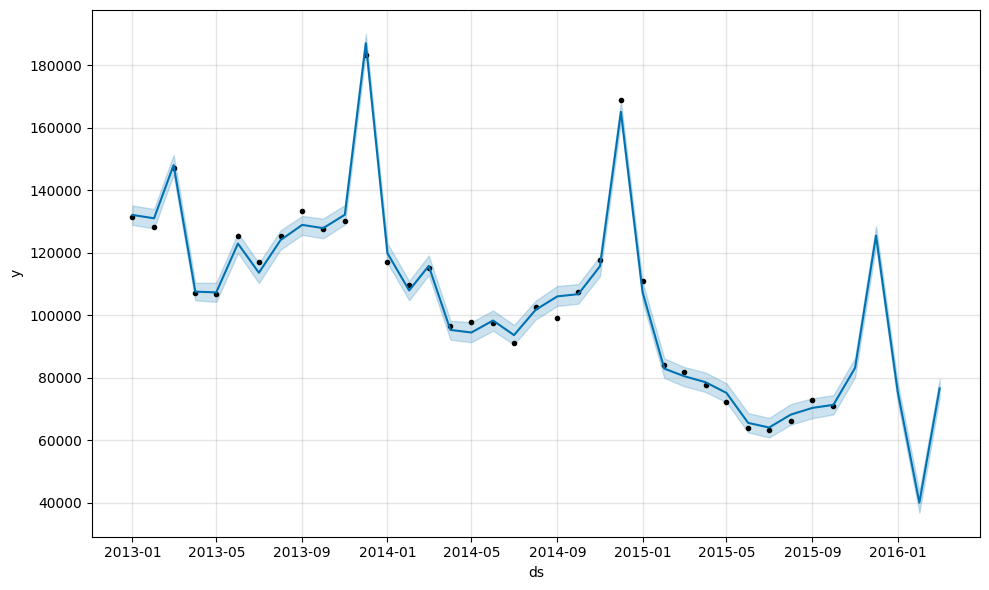

In [ ]:
model.plot(forecast)

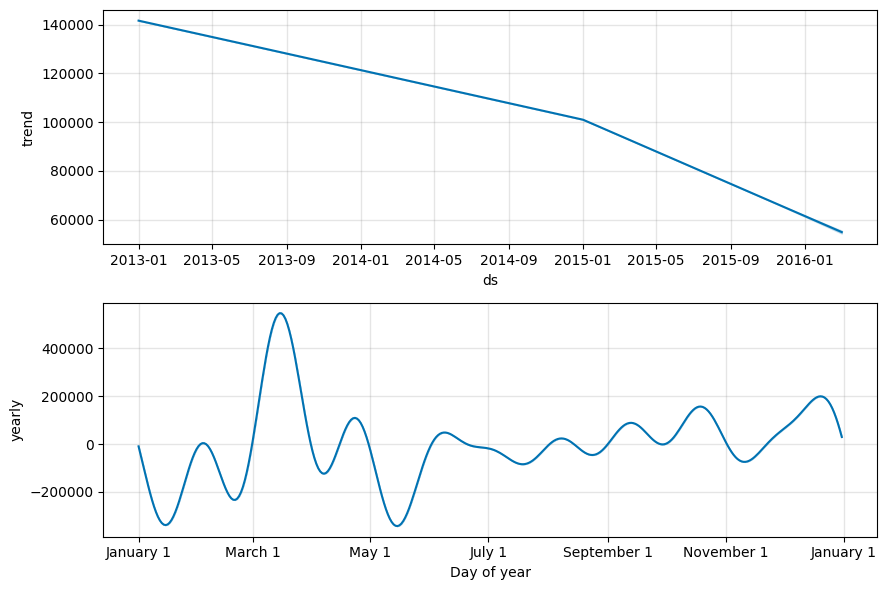

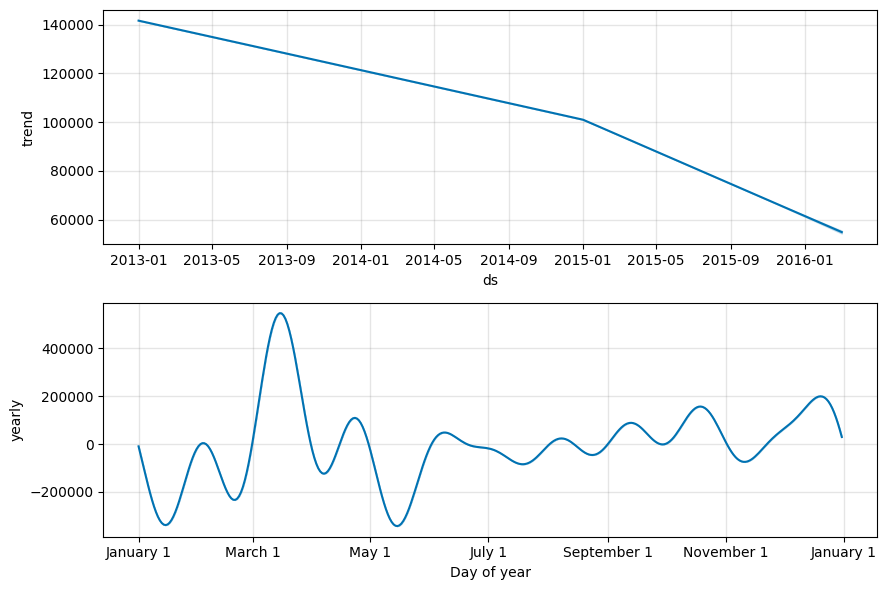

In [ ]:
# plot the model forecast chart with component charts in trend and seasonality  
model.plot_components(forecast)
# 예측치가 어떤 구성요소로 되어있는지 볼 수 있었다.

In [ ]:
# Show all forecasting values in a table
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-01,132111.364801,128918.015508,135121.876515
1,2013-02-01,131029.341282,127824.055937,134005.384325
2,2013-03-01,148046.370868,144998.859126,151341.373734
3,2013-04-01,107581.691815,104791.771328,110403.732210
4,2013-05-01,107336.513704,104313.459007,110416.314116
5,2013-06-01,122945.911532,119937.142355,126285.318507
6,2013-07-01,113630.281139,110318.801080,116711.552953
7,2013-08-01,124068.202876,121042.117862,127186.817594
8,2013-09-01,128923.845484,125741.636247,131776.708848
9,2013-10-01,127879.371657,124633.020599,130942.789439
